# Replication Michael P. Keane & Kenneth I. Wopin

This notebook replicates results from: 

Keane, M. P. & Wopin, W. I. (1997). [The career Decisions of Young Men.](https://www.jstor.org/stable/10.1086/262080)
 *Journal of Political Economy, 105(3): 473-552.*

The above mentioned paper builds on the theoratical paper from:

Keane, M. P. & Wopin, W. I., & Vytlacil, E. J. (1994). 
[The Solution and Estimation of Discrete Choice Dynamic Programming Models by Simulation and Interpolation: Monte Carlo Evidence.](https://www.jstor.org/stable/2109768)
 *The Review of Economics and Statistics, 76(4): 648-672.*

For this purpose l rely on the  *respy* and *estimagic* open-source python packages. [*Respy*](https://github.com/OpenSourceEconomics/respy) is for the simulation and estimation of a prototypical finite-horizon discrete choice dynamic programming model and [*Estimagic*](https://github.com/OpenSourceEconomics/estimagic) helps to build high-quality and user friendly implementations of (structural) econometric models.

In **section I**, l give an introduction to the project, my motivation for replicating KW1997 as well what motivates the paper. I replicate the descriptive statistics of the data and illustrate them graphically in **section II**. It should be kept in mind whilst interpreting the graphs, that as the number of periods increase, sample attrition plays a role. In **section III**, l discuss the theoretical framework of the paper, which ties back to the descriptive statistics in section 2, as well as develop a causal graphical framework for the model.  I then reproduce the main results in **section IV** using the *respy* and *estimagic* packages and calculate standard errors for the estimated parameters. In **section V**, l discuss the results of the paper and a short assessment of the extended model which in turn concludes my contribution to the replication of KW1997.

# Section I: Background

#### Motivation for replicating KW1997

Often times, the research outcomes that emerge from data in the developed world's context do not easily replicate in a developing country setting. However, many lessons could be drawn from them to learn something about human capital formation for low income countries (LICs). I chose to replicate this paper to learn more about structural econometric methods in a human capital formation setting. I hope to apply my knowledge to address questions, in the future, such as how to increase the level of skill acquired in the higher education system such that the up and coming generation of the African workforce is well equipped for competent roles in the labor market. Ultimately, this could inform policy to help achieve the African Union's 2063 vision - to build an integrated, prosperous and peaceful Africa, driven by its own citizens.

#### Groundwork 

This project builds upon collaboration and contributions to the *respy* and *estimagic* open source packages. In particular, l have worked with some of the open source contributors of these packages to develop parts of the code.

For the *respy* package, l have integrated the results of a project l previously completed on [benchmarking various implementations of ols and iv ](https://github.com/lindamaok899/least_squares). This was done to drop all statsmodels dependencies in the package in favor of incorporating a faster method of calculating ols estimates. I have also integrated a root mean squared error (rmse) function in the package for the same purpose.

For the *estimagic* package, l have worked on the documentation of the numerical optimizers used in the package. In particular, l have created reference dictionaries for the different arguments that relate to the various implemented numerical optimizers.

For both packages and an additional project (*uncertainty quantification project*), l write functions that construct the full covariance matrix of the estimated parameters of maximum likelihood models. There are different ways to calculate those covariance matrices, but in all cases they are based on derivatives of the log likelihood function. I have also written a function that extracts the diagonal elements of these covariance matrices to construct a 1d array containing the standard errors, both of which could be found in [this](https://github.com/OpenSourceEconomics/estimagic/blob/likelihood_inference/estimagic/inference/likelihood_covs.py) module. To ensure integrity of the functions, l have written a benchmarking module that compares the functions to the statsmodels output which can be found [here](https://github.com/lindamaok899/standard_errors/blob/master/code/benchmark_results.py). Lastly, l have written [tests](https://github.com/OpenSourceEconomics/estimagic/blob/likelihood_inference/estimagic/tests/inference/test_likelihood_covs.py) for all the maximum likelihood covariance matrix functions.


#### Authors' motivation

This paper provides structural estimates of schooling, work and occupational choice decisions based on 11 years of observations on a sample of 1373 white young men from the 1979 youth cohort of the National Longitudinal Surveys of Labor Market Experience (NLSY). The authors ingeminate the importance of incorporating self selection for an accurate assessment of the differential productivity of human capital investment. In their paper, they extend earlier (prior to 1997) work done in the this field by considering self-selection in the three dimensions of schooling, work and occupational choice. More specifically, they extend the static deterministic setting of earlier models (Heckman and Sedlacek, 1985; Willis, 1986), each of which is an extension of the basic Roy (1951) framework, to a model in which decision making is sequential and the environment is uncertain.

The structural approach in Keane and Wopin (1997) provides rigorous interpretations for the parameters that are estimated, which has several important implications for ex-ante policy evaluation such as:

1) predicting the effect an intervention that provides college tuition subsidies has on college attendance rates and subsequent occupational choice decisions

2) assessing the welfare effects of interventions on lifetime wealth and utility, allowing policy makers to draw distributional consequences of them 

To implement the model, the participants are assigned in each year to one of five discrete, mutually exclusive alternatives: attending school, working in a white collar occupation, working in a blue collar occupation, working in the military or engaging on home production.

# Section II: Data & Visualisation

#### Data loading and processing

First, l import the necessary packages.

In [55]:
%matplotlib inline

import pandas as pd
import numpy as np
import os
import respy as rp
from estimagic.differentiation import *
from estimagic.inference.likelihood_covs import *
from respy.likelihood import *
import seaborn as sns
import matplotlib.pyplot as plt
from auxiliary.auxiliary import *
import warnings
import subprocess
from IPython.display import display, Math, Latex, Image

sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(12, 6)})
sns.set_style('ticks')

warnings.simplefilter(action='ignore')

Subsequently, l also load simulated data from respy to combat memory error issues.

In [2]:
#cmd = 'python auxiliary/generate_simulated_data.py {}'
#for model in 'kw_97_base', 'kw_97_extended':
    #os.system(cmd.format(model))
    #process = subprocess.Popen(cmd.format(model), shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    #process.communicate()
    #  , stdout=subprocess.PIPE, stderr=subprocess.STDOUT, check=True

In [3]:
#cmd = 'python auxiliary/generate_simulated_data.py {}'
#for model in 'kw_97_base', 'kw_97_extended':

    #rc = subprocess.call(cmd.format(model), stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    #if rc == 0: # found
       #...
    #elif rc == 1: # not found
       #...
    #elif rc > 1: # error
       #...
#rc

I then conduct some basic data preparation and pre-processing to increase readability.

In [4]:
# Ensure proper formatting of the wage variable
pd.options.display.float_format = '{:,.2f}'.format

# Label and format the different columns
columns = ['Identifier', 'Age', 'Schooling', 'Choice', 'Wage']
dtype = {'Identifier': np.int, 'Age': np.int,  'Schooling': np.int,  'Choice': 'category'}

# Read the original data file
df = pd.DataFrame(np.genfromtxt('data/KW_97.raw'), columns=columns).astype(dtype)

# Label the different choice categories
df['Choice'].cat.categories = ['Schooling', 'Home', 'White', 'Blue', 'Military']

# Set the index for easier interpretability
df['Period'] = df['Age'] - 16
df.set_index(['Identifier', 'Period'], inplace=True, drop=True)

#### Data description

All individuals enter the model initially at the same age and are then observed for a varying number of consecutive years. Each year, the individual's decision to work in either a white or blue collar occupation, attend school, enroll in the military, or remain at home. The decision tree below illustrates this.

![](material/decision_tree.PNG)

If the individual is working, the dataset potentially also contains that year's wage as a full-time equivalent. As can be seen from the replication of table 1 below, there is considerable missing wage information, particularly at the younger ages and for blue collar employment.

In [5]:
# preview the data
df.head()

Age  Schooling     Choice  Wage
Identifier Period                                 
6          0        16         11  Schooling   nan
           1        17         12  Schooling   nan
           2        18         13  Schooling   nan
           3        19         14  Schooling   nan
           4        20         15  Schooling   nan

In [6]:
df_unindexed = df.reset_index().rename(columns={0:'value'})
df_unindexed.head()

,Identifier,Period,Age,Schooling,Choice,Wage
0,6,0,16,11,Schooling,nan
1,6,1,17,12,Schooling,nan
2,6,2,18,13,Schooling,nan
3,6,3,19,14,Schooling,nan
4,6,4,20,15,Schooling,nan


#### Sample size distribution by age

The sample size seems to decrease as the periods increase, most likely attributable to sample attrition.

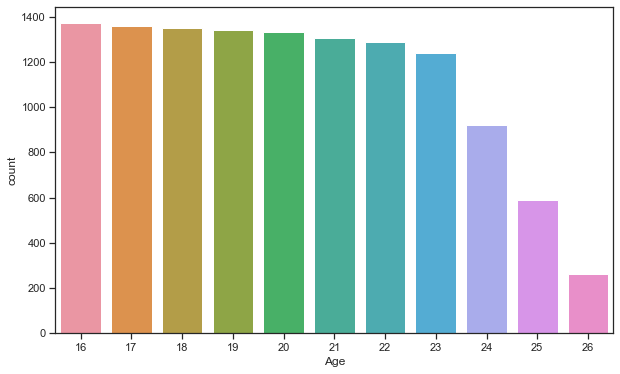

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(df['Age'])

##### Years of schooling in initial period
This plot illustrates the given level of schooling at age 16. barplot below illustrates that there is observed heterogeneity in school starting years with a number of people falling within the 10 and 11 year age range. It is plausible that the people with years of schooling below 10 years may have dropped out of school, whilst the ones above 11 years could be as a result of a data anomaly.

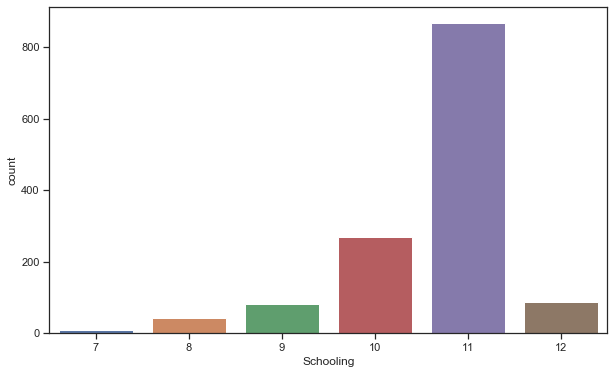

In [8]:
initial_schooling(df_unindexed)

#### Wages

The figures below show that occupation-specific wage is increasing in age and years of experience. Returns to schooling are larger in white-collar jobs. While the initial wage is lower, it does increase rapidly with schooling compared as compared to the blue-collar professions.

##### Average real wage by occupation as in Table 4
The table shows age-specific average real wages overall and by occupation. White- and blue-collar occupations are very similar through age 21. However, after this age, white-collar wages are, on average, about 20 percent higher. Military ages are the lowest at all ages. 

In [9]:
tab = pd.crosstab(index=df['Age'], columns=df['Choice'], values=df['Wage'], aggfunc='mean', margins=True)
tab[['All', 'White', 'Blue', 'Military']]

Choice,All,White,Blue,Military
Age,,,,
16,"10,217.74","9,320.76","10,286.74",nan
17,"11,036.60","10,049.76","11,572.89","9,005.36"
18,"12,060.75","11,775.34","12,603.82","10,171.87"
19,"12,246.68","12,376.42","12,949.84","9,714.60"
20,"13,635.87","13,824.01","14,363.66","10,852.51"
21,"14,977.00","15,578.14","15,313.45","12,619.37"
22,"17,561.28","20,236.08","16,947.90","13,771.56"
23,"18,719.84","20,745.56","17,884.95","14,868.65"
24,"20,942.42","24,066.64","19,245.19","15,910.84"


We see in the plot below that occupational choices exhibit persistence.

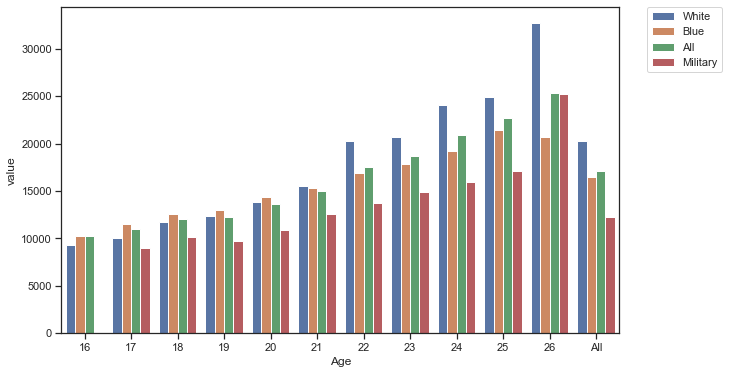

In [10]:
occupational_choice(tab)

##### Real wage per period within the choice set

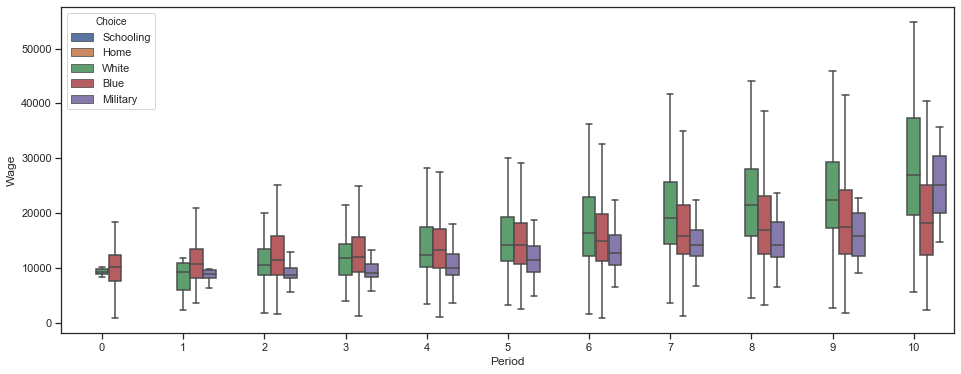

In [11]:
real_wage(df_unindexed)

##### Relationship between wage and years of schooling

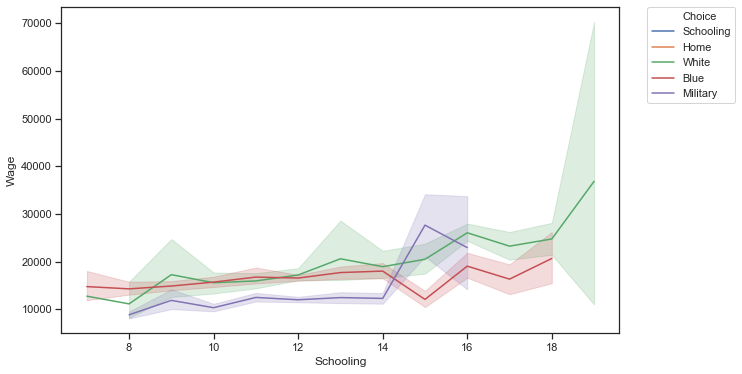

In [12]:
wage_schooling(df)

#### Choice

This sub-section shows graphically, different attributes of the choices to illustrate the variables in the dataset. 

The subsequent figures below illustrate that (i) school attendance should decline with age, and that (ii) employment should increase with age. We see that participation in both white- and blue-collar occupations increase monotonically, but at different rates. What is noteworthy is that participation in blue-collar occupations is essentially unchanged after age 22, whereas white collar participation almost doubles between ages 22 and 25. It is evident from the graphs, that there is a close connection between leaving school at college-going ages and moving into white-collar employment. In contrast to civilian occupations, participating in the military quickly increases to a peak at age 20, then declines at about age 25.

##### Number of individuals per choice

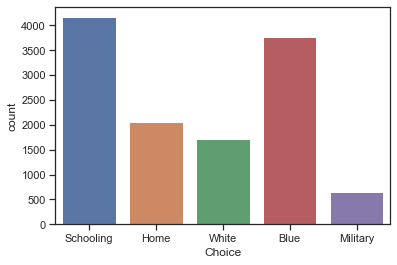

In [13]:
sns.countplot(df['Choice'])
plt.show()

##### Average age by choice

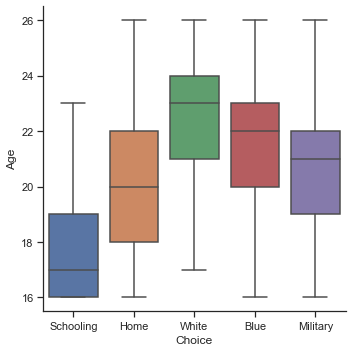

In [14]:
# Outliers excluded from this plot, to include them showfliers=True
sns.catplot(x="Choice", y="Age", kind="box", data=df, showfliers=False)
plt.show()

##### Average school attainment by choice

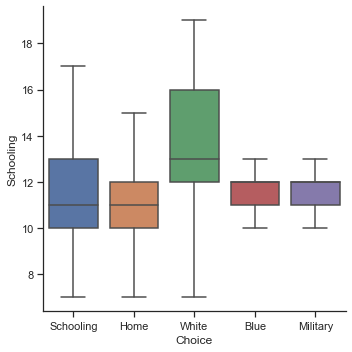

In [15]:
# outliers excluded in this plot, to include them showfliers=True
sns.catplot(x="Choice", y="Schooling", kind="box", data=df, showfliers=False)
plt.show()

##### Choice distribution by age as in Table 1
From the table below, we see that the vast majority of the sample, approximately 86%, is in school at age 16. 

In [16]:
table = pd.crosstab(index=df['Age'], columns=df['Choice'], margins=True)
table

Choice,Schooling,Home,White,Blue,Military,All
Age,,,,,,
16,1178,145,4,45,1,1373
17,1014,197,15,113,20,1359
18,561,296,92,331,70,1350
19,420,293,115,406,107,1341
20,341,273,149,454,113,1330
21,275,257,170,498,106,1306
22,169,212,256,559,90,1286
23,105,185,336,546,68,1240
24,65,112,284,416,44,921


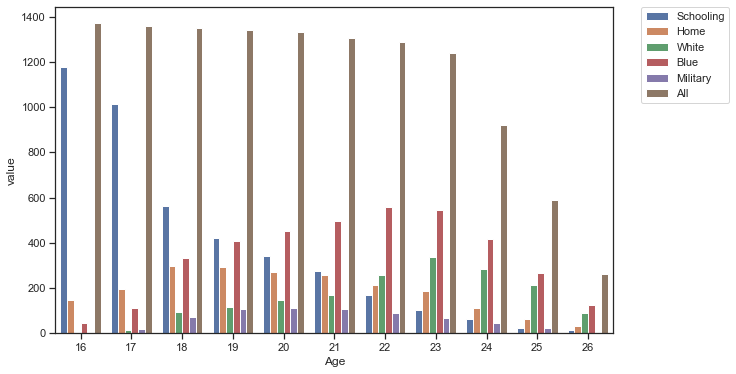

In [17]:
choice_dist(table)

##### Proportion of people choosing certain choices per period as in Table 3 (row 2)
These figures show the proportion choosing each choice from the choice set (unconditionally).

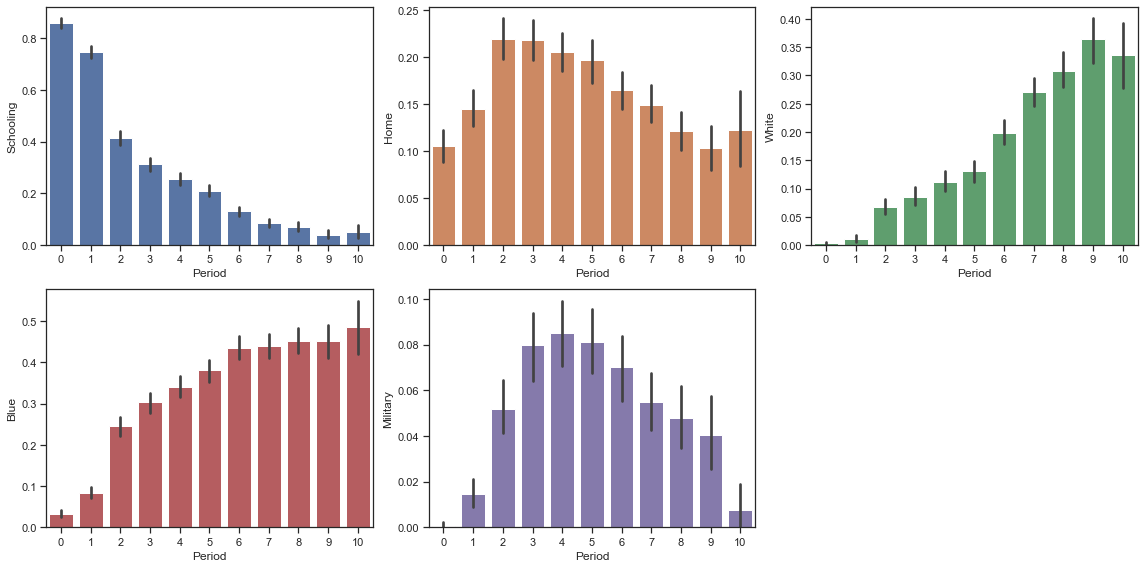

In [18]:
plot_bars(df_unindexed, ax)

#### Occupational transitions
Below, l replicate Table 2 in the paper that shows one period transition rates, illustrating persistence in choice over periods.
My reproduced results deviate in some rows/columns from the results in the paper. A plausible explanation would be that what l have done below ensures precision in calculation i.e normalizing row-wise) which may not have been the case when this paper was authored. Nonetheless, the results indicate the same as what has been documented in KW1997 with a few misaligned figures within the table.

In [19]:
data = df_unindexed.copy()
data['next_period'] = data['Period'] + 1
choice_data = df_unindexed[['Identifier', 'Period', 'Choice']]
choice_data.rename(columns={'Choice': 'NextChoice'}, inplace=True)

combined = pd.merge(
    left=data, 
    right=choice_data, 
    left_on=['Identifier', 'next_period'],
    right_on=['Identifier', 'Period'], 
    how='left', 
    suffixes=['', '_next'],
)
combined.drop(columns=['Period_next', 'next_period'], inplace=True)

# only first row is different from paper
tab_rows = (pd.crosstab(index=combined['Choice'], columns=combined['NextChoice'], normalize='index') * 100).round(1)

# all are different from paper because the normalization divides by sum over rows
tab_cols = (pd.crosstab(index=combined['Choice'], columns=combined['NextChoice'], normalize='columns') * 100).round(1)


# produces tables
# the first table (tab_rows) is the percentage of transitions from origin to destination i.e the row percentage
# the second table (tab_cols) is the percentage in a particular destination who started from each origin i.e column percentage
list_dfs = []
list_dfs.append( tab_rows )
list_dfs.append( tab_cols )
multi_column_df_display(list_dfs)

NextChoice,Schooling,Home,White,Blue,Military
Choice,,,,,
Schooling,64.50,13.00,8.60,12.10,1.80
Home,9.80,47.20,8.10,31.30,3.70
White,5.70,6.30,67.40,19.90,0.70
Blue,3.40,12.40,9.90,73.40,0.90
Military,1.40,5.50,3.10,9.60,80.40
NextChoice,Schooling,Home,White,Blue,Military
Choice,,,,,
Schooling,87.50,27.50,20.30,13.20,11.00
Home,6.10,46.10,8.80,15.80,10.70


The heatmaps below represent the data in the tables above. We can observe considerable immobility out of the home alternative, with the indication that subjects that begin at home are also at home in the next period. The heatmaps also show substantial state dependence in occupation-specific employment for example, a majority of the people who are employed in white-collar occupations in one period are in white-collar occupations in the next, and the reverse is also true. 

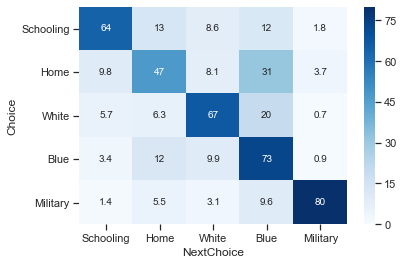

In [20]:
# this heatmap is the percentage of transitions from origin to destination i.e the row percentage
sns.heatmap(tab_rows, cmap='Blues', vmin=0, vmax=80, annot=True)
plt.show()

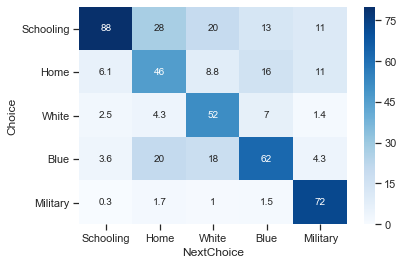

In [21]:
# the second table (tab_cols) is the percentage in a particular destination who started from each origin i.e column percentage
sns.heatmap(tab_cols, cmap='Blues', vmin=0, vmax=80, annot=True)
plt.show()

##### Age pattern of inter-occupational transitions (not shown in paper)
Here l illustrate with period-wise heatmaps that, the age pattern of inter-occupational transitions differs considerably. After age 21 for example, transitions from white- to blue-collar occupations drop considerably.  

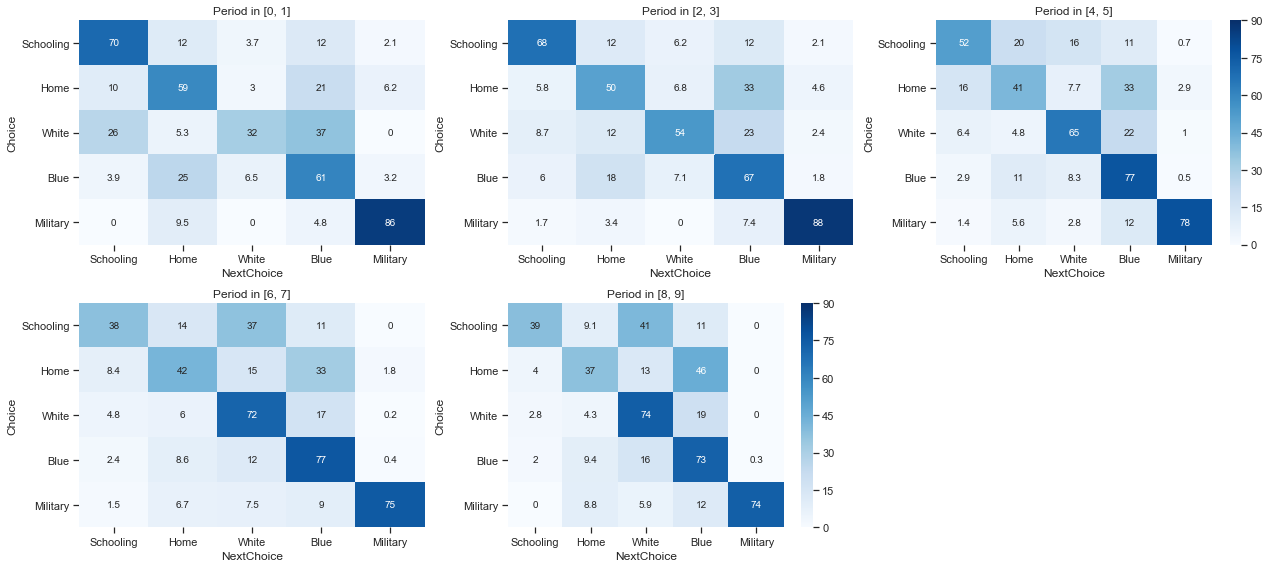

In [22]:
period_pairs_rows(combined)

The reverse transition, shown below, from white- to blue-collar jobs increases with age, supporting the notion from above.

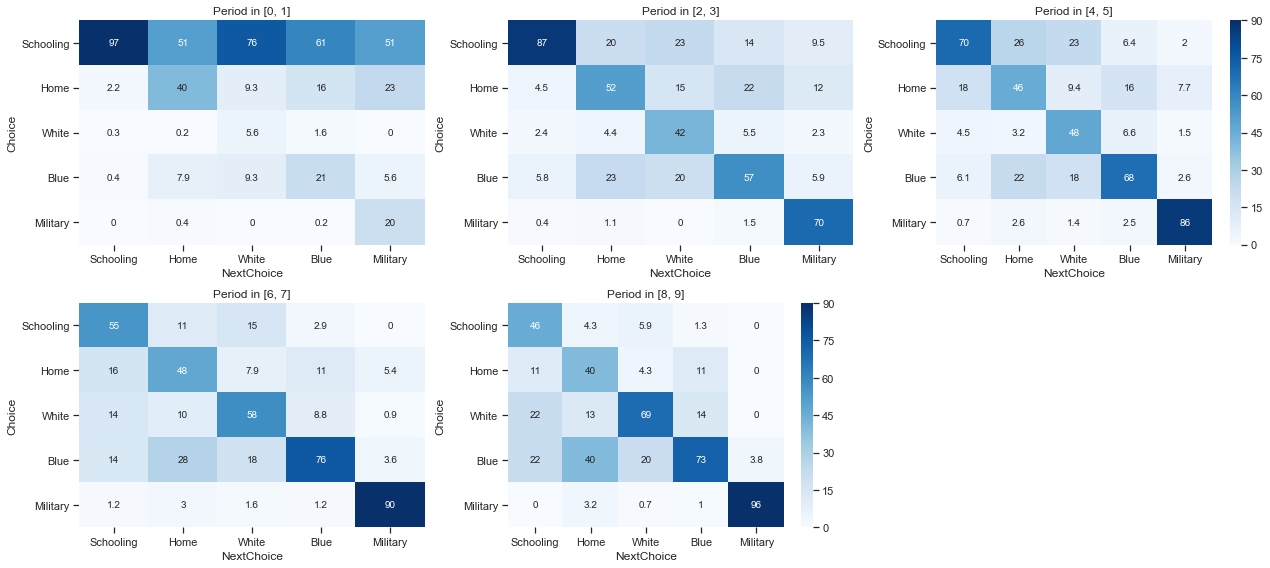

In [23]:
period_pairs_cols(combined)

## Section III: Theoretical Framework

The authors estimate a basic human capital model against the data descriptives presented in the previous section and a data simulation of 5,000 individuals to illustrate that the basic human capital model, overall, does not provide a good fit to capture the quantitative features of the NLSY data. 

#### Why is the basic human capital model not a good fit?

In assessing the basic model, the authors consider three criteria: (1) the reasonableness of the parameter values, (2) the within-sample fit, and (3) out-of-sample fit. The basic model seems to generate parameter values that are within reasonable ranges. KW1997 then use the simulated data to assess within-sample fit and report that there occurs some discrepancies (underestimation) with respect to the schooling, military and home alternatives, although the qualitative age patterns are replicated. The basic model does not capture well the persistence in choices that are observed in the replication of tables 2 and 3 above. The authors report the model as seemingly tracking more closely, the effects of occupation-specific work experience on choice as in table 3, except for understanding the impact of the first year of experience. The model predicts that the first year of white- (blue-) collar experience increases the probability of choosing the white- (blue-) collar alternative by 15(27) percentage points versus the 31- (37) percentage-point increase as shown in the heatmaps above. The basic model does not produce reasonable forecasts for the out-of-sample fit measure as well.

##### Open issues from basic model:
- distinction between ex-ante and ex-post returns
- role of psychic costs
- non-linearities in the return
- role of uncertainty

#### The extended model

The authors attempt to better fit the data by extending the basic human capital model in the direction motivated by the shortcomings of the basic model. The model extension serves to improve the overall distribution (replicated as table 1 above) and the pattern of persistence (replicated as table 2 and 3 above). After replicating the main results of the extended model in section 4, l present the results of an evaluation of the model extension using the same criteria as that of the basic model.

### Models and Notation

I outline the economic, mathematical and computational models next to have some structure for when l replicate the results, but first, some notation:

\begin{align*}
&&&&\\
&&&&\\
 &\text{t = 1,...,T} & & \text{decision period}  &\\
 &{s \in S} & & \text{state}  &\\
 &{a \in A} & & \text{action}  &\\
 &d_t(s) & & \text{decision rule}  &\\
 &r_t(s, a) & & \text{immediate reward}  &\\
 &\pi = (d_{1},...,d_{T}) & & \text{policy}  &\\
 &h_{t} = (s_{1}, a_{1},...,s_{t}) & & \text{history}  &\\
 &\delta & & \text{discount factor}  &\\
 &p_t(s, a) & & \text{conditional distribution}  & 
 &&&&\\
\end{align*}


#### The Economic Model

#### Timeline of events
The standard method for solving the individual's finite-horizon optimization problem is to use backward induction. An individual enters the last period a=A, with a particular schooling and job history. At A the individual draws random shocks for the joint $e_{m}(a)$ distribution, uses them to calculate the rewards, and chooses the alternative with the highest realized reward. 


![](material/timing.PNG)

#### Individual's objective function under risk 
Moving backwards, the individual must maximize the value function:

\begin{align*}
&&&&\\
& v_{1}^{\pi^*} = \max_{\pi \in \Pi} E_s^{\pi} \left[\sum^T_{t=1} \delta^{t-1} r_t(X_t,d_t(X_t)) \right] \\ 
&&&&\\
\end{align*}

#### The Mathematical Model

#### Policy Evaluation
The optimal policy is then the expectation of discounted optimal per period rewards, represented as:

\begin{align*}
&&&&\\
&&&&\\
v^\pi_t(s) = E^\pi_{s}\left[ \sum^T_{\tau=t} \delta^{\tau - t}   r_\tau(X_\tau, d_\tau(X_\tau)) \right]\\
&&&&\\
&&&&\\
\end{align*}


#### Inductive Scheme

\begin{align*}
&&&& \\
&&&&\\
v^\pi_t(s) = r_t(s, d_t(s)) + \delta E^\pi_{s} \left[v^\pi_{t + 1}(X_{t + 1})\right]
&&&&\\
&&&& \\
\end{align*}

#### Optimality Equations

\begin{align*}\label{MPD Optimality}
&&&&\\
&&&& \\
v^{\pi^*}_t(s) = \max_{a \in A}\bigg\{ r_t(s, a) + \delta E^p_{s} \left[v^{\pi^*}_{t + 1}(X_{t + 1})\right] \bigg\}.
&&&&\\
&&&& \\
\end{align*}

#### The Computational Model
The extensions, as mentioned above, serve to improve the overall choice distribution (table 1) and the pattern of persistence (table 2 & 3). The improvements cover work alternatives, school attendance, remaining at home and common returns - outlines in the following discussions of the computational model.

#### Additional notation

\begin{align*}\begin{array}{ll}
t & \text{age} \\
k       & \text{unobserved type} \\
x_{j,t} & \text{experience in occupation j at age t} \\
a_t     & \text{action at age j} \\
g_t     & \text{level of schooling at age t}
\end{array}\end{align*}


#### Skill technology Functions
The civilian skill production functions where augmented, through dummy variables, to allow for a skill depreciation effect, a first year experience effect, age effects, as well as high school and college graduation effects as shown below:

\begin{align*}
&&&&&& \\
e_{j,k,t} & =  \exp\{ e_{j,k,16}+ \underbrace{\alpha_{j,1} g_t + \alpha_{j,2} I[g_t \geq 12] + \alpha_{j,3} I[g_t \geq 16]}_{\text{schooling}}\\
                & + \underbrace{\alpha_{j,4} x_{j,t} + \alpha_{j,5} x^2_{j, t} + \alpha_{j,6} I[x_{j, t} > 0] + \alpha_{j,7} x_{j\neq j^\prime, t}}_{\text{work experience}}  \\
                & + \underbrace{\alpha_{j,8}I[a_{t - 1} \neq j] }_{\text{depreciation}} + \alpha_{j,9} (t - 16) + \alpha_{j,10} I[t < 18] + \epsilon_{j, t}\}
\end{align*}

with $j, j^\prime = 1, 2$, $k = 1, \dots,4$, and $t=16,\dots,65$






#### Labour Market
The reward functions for the civilian occupations were augmented to include a direct monetary job-finding cost as well as an additional job-finding costs. These additional state variables parallel the ones added to the skill functions. The extension below also allows for indirect compensation by accommodating non-wage aspects of employment. The extended model also allows for common returns as shown below: 

\begin{align*}
&&&& \\
r_{j,k,t} & =   w_{j,k,t} + \underbrace{\kappa_{1}I[g_t \geq 12] + \kappa_{2} I[g_t \geq 16]}_{\text{common returns}} + \beta_{j,1} \\
          & + \underbrace{\beta_{j,2}I[x_{j,t} > 0, a_{t-1}\neq j] + \beta_{j,3}I[x_{j, t} = 0, a_{t-1}\neq j ]}_{\text{entry cost}}
\end{align*}

with $w_{j,k, t} = r_j e_{j,k,t}$




#### School
The schooling reward is more generally interpreted to include a consumption value of school attendance and is allowed to depend systemically on age. In addition, the reward associated with attending school includes a cost of re-entry into high school,  a seperate re-entry cost into post secondary school and common returns as indicated below:

\begin{align*}
r_{3,k,t} & = e_{3,k,16} + \underbrace{\gamma_{1}I[g_t \geq 12] + \gamma_{2} I[g_t \geq 16]}_{\text{monetary and psychic cost}} \\
         & + \underbrace{\gamma_{3} I[a_{t -1} \neq 3, g_t \leq 11]  + \gamma_{4} I[a_{t -1} \neq 3, g_t \geq 12]}_{\text{reenrollment cost}}  \\
         & + \gamma_{5} (t - 16) + \gamma_{6} I[t \le 18] + \underbrace{\kappa_{1}I[g_t \geq 12] + \kappa_{2} I[g_t \geq 16]}_{\text{common returns}} \\
         & + \epsilon_{3,t}
\end{align*}

#### Home
The payoff from remaining home is allowed to differ by age in the below equation by a dummy variable indicating whether the individual is in the age range 18-20 and 21 over as shown here:

\begin{align*}
r_{4,k,t} & = e_{4,k,16} + \zeta_{1} I[18 \leq t \leq 20] +  \zeta_{2} I[t \geq 21] \\
          & + \underbrace{\kappa_{1}I[g_t \geq 12] + \kappa_{2} I[g_t \geq 16]}_{\text{common returns}} + \epsilon_{4,t}
\end{align*}


#### State space

- at time $t$

\begin{align*}
s_t  = & \{g_t,  \{x_{j, t}\}_{j=1,2}, a_{t-1}, \{\epsilon_{j, t}\}_{j=1,\dots,4}\}\\
\bar{s}_t  = & \{g_t,  \{x_{j, t}\}_{j=1,2}, a_{t-1}\}
\end{align*}


- laws of motion

\begin{align*}
x_{j,t + 1} & = x_{j,t} + I[a_t = j]  \qquad\forall\quad j \in \{1, 2\}  \\[1em]
g_{t + 1}    & = g_t + I[a_t = 3]
\end{align*}

##### Distribution of shocks

\begin{align*}
[\epsilon_{1,t}, \epsilon_{2,t}, \epsilon_{3,t}, \epsilon_{4,t}]^T \sim \mathcal{N}_0(\vec{0}, \Sigma)\\
\end{align*}

#### Initial conditions

- Skill endowments:

\begin{align*}
e_{1k}(16), e_{2k}(16), e_{3k}(16), e_{4k}(16), e_{5k}(16).
\end{align*}

- School attainment: $g(16)$ given.
- Work experience: $x_{m}(16) = 0$
- State space: 

\begin{align*}
S(a) = {S(16), a, g(a), x_{m}(a): {m = 1, 2, 3}, d_{m}(a - 1): {m = 1, 2, 4}, e_{m}(a): {1, \dots,5}}.
\end{align*}

### Causal Graph
The authors take into account unobserved endowment heterogeneity in determining inequality in lifetime welfare by categorizing observations by type (1-4). although you cannot observe an individual's type directly, they use Baye's rule to compute the probability distribution of the endowment types conditioning on choices, wages and initial schooling. Having calculated these endowment type probabilities for each individual, they determine the extent to which observed family background characteristics are relevant to type. The results indicate that standard measures of family background account for 10% of the variation in expected lifetime utility that arises from endowment heterogeneity. Therefore, the authors note that in order to understand the sources of endowment heterogeneity, given its importance in the determination of the life-time well-being, obtaining measurements of investments in children before age 16, including prenatal care and maternal behaviors during pregnancy, child care, child nutrition, grade school experiences, and so forth, would seem to be a critical endeavor. 

#### Extended model causal graph
The following causal graph relates to the extended model by KW1997, l indicate that there could potentially be some unobservable endowment heterogeneity present arising from early childhood investments, that could influence the initial observed state-space at age 16 (as discussed above) in the causal graph below:


## Section IV: Replication of main result

### Contribution to replicating KW1997
To fully replicate the results from KW1997, there is need to calculate the standard errors from the maximum likelihood estimates produced by the *respy* package. Because the maximum likelihood (ML) method does not automatically calculate the standard errors for you, it is neccesary to write functions that implement the calculation of standard errors. For this reason, l have written functions that calculate covariance matrices for hessian and jacobian matrices for the purposes of replicating the main results of the paper in Table 7. These functions have since been encorporated into the [estimagic/inference](https://github.com/OpenSourceEconomics/estimagic/tree/master/estimagic/inference) folder for calculating standard errors. The tests for these functions can also be found in the [estimagic/tests/inference](https://github.com/OpenSourceEconomics/estimagic/tree/master/estimagic/tests/inference) folder.

#### Constructing covariance matrices
The covariance matrix V is determined by the shape of the loglikelihood function. To describe it in the general case, we define the information in observation $i$ as:

\begin{align*}
I_i(\theta) \equiv -E\bigg\{ \frac{\partial^2 logL(\theta)}{\partial\theta\partial\theta'} \bigg\},
\end{align*}

which is a $K x K$ matrix. Loosely speaking, this matrix summarizes the expected amount of information about $\theta$ contained in observation $i$. The  average information matrix for a sample of size $N$ is defined as:

\begin{align*}
\bar{I}_N(\theta) \equiv \frac{1}{N} \sum^N_{i=1} I_i(\theta) = -E\bigg\{ \frac{1}{N} \frac{\partial^2 logL(\theta)},{\partial\theta\partial\theta'} \bigg\}
\end{align*}

Under appropriate regularity conditions, the asymptotic covariance matrix of the maximum likelihood estimator can be shown to equal the inverse of the information matrix, that is,

\begin{align*}
V = I(\theta)^{-1}.
\end{align*}

#### Hessian covariance matrix
In practice the covariance matrix V can be estimated consistently by replacing the expectations operator with a sample average and replacing the unknown coefficients with the maximum likelihood estimates. That is,

\begin{align*}
\hat{V}_H =\left(\ -\frac{1}{N} \sum^N_{i=1} \frac{\partial^2 logL(\theta)}{\partial\theta\partial\theta'} \Bigg|_{\hat{\theta}} \right)^{-1},
\end{align*}

where we take derivatives first and in the result replace the unknown $\theta$ with $\hat{\theta}$. The suffix H is used to stress that the estimator for V is based upon the **Hessian** matrix, the matrix of second derivatives.

##### features
- typically possesses somewhat better properties for use in estimation for small samples

#### Jacobian covariance matrix
An alternative expression for the information matrix can be obtained from the result that the matrix

\begin{align*}
J_i(\theta) \equiv E\{s_i(\theta)s_i(\theta)'\},
\end{align*}

with $s_i(\theta)$ defined as:

\begin{align*}
s(\theta) \equiv \frac{\partial logL(\theta)}{\partial \theta} = \sum^N_{i=1} \frac{\partial log L_i(\theta)}{\partial\theta} \equiv \sum^N_{i=1}s_i(\theta),
\end{align*}

which is identical to $I_i(\theta)$, provided that the likelihood function is correctly specified.

The above indicates that V can also be estimated from the first-order derivatives of the likelihood function as:

\begin{align*}
\hat{V}_G =\left(\ -\frac{1}{N} \sum^N_{i=1} s_i(\hat{\theta}) s_i(\hat{\theta})' \right)^{-1},
\end{align*}

where the suffix G reflects that the estimator employs the outer product of the gradients (first derivatives) or the **Jacobian** matrix. 

##### features
- requires the individual likelihood contributions

#### HJJH covariance matrix
This estimator computes the covariance of parameters based on $HJJH$ dot product of Hessian, Jacobian, Jacobian, Hessian of the likelihood. This is an adopted implementation from the *statsmodels* package and would be useful for me to compare the results of the standard errors from this method with the ones from the previously mentioned methods.

#### Which method is better?
In general, the covariance matrix estimates $\hat{V}_H$, $\hat{V}_G$ and $HJJH$ will not be identical. The hessian estimator typically has somewhat better properties in small samples. This is particularly beneficial perhaps for structural econometric applications as the samples sizes are typically smaller. Nontheless, a good practice would be to compute all three types of standard errors and compare the results.

#### Method used by KW1997
The authors use the outer product of numerical first derivatives (hessian) to calculate standard errors. In their earlier paper (Keane & Wolpin 1994), they find that, on the basis of monte carlo simulations, these standard errors seemed to be downward biased. It would be interesting to capmare the results from the hessian covariance matrix with the jacobian and see what the margins of difference are.

### Estimated occupation-specific parameters (Table 7)

#### load and visualize simulated datasets
For the purposes of visualization, l simulate data for upto 40 periods to compare the basic and extended models. Later on, for calculation of  standard errors, l use the real dataset from respy (using the *get_example_model*) function.

In [56]:
# load pickled basic model data
respy_basic = pd.read_pickle("simulated_data/kw_97_base.pickle")

# basic model dataset
respy_basic.head()

,Identifier,Period,Choice,Wage,Experience_A,Experience_B,Experience_Mil,Experience_Edu,Lagged_Choice,Type,...,Value_Function_B,Value_Function_Mil,Value_Function_Edu,Value_Function_Home,Shock_Reward_A,Shock_Reward_B,Shock_Reward_Mil,Shock_Reward_Edu,Shock_Reward_Home,Discount_Rate
0,0,0,edu,nan,0,0,0,7,edu,2,...,"82,999.99","79,002.02","85,555.13","59,894.77",0.83,1.60,1.40,"1,333.41","-7,298.72",0.79
1,0,1,edu,nan,0,0,0,8,edu,2,...,"79,428.58","78,332.80","91,022.17","78,923.83",1.16,0.57,0.78,"2,406.64","8,085.82",0.79
2,0,2,edu,nan,0,0,0,9,edu,2,...,"86,625.50","82,890.56","96,035.48","77,278.15",1.19,0.85,0.85,"2,197.76","2,075.72",0.79
3,0,3,a,"27,322.80",0,0,0,10,edu,2,...,"92,416.93","87,148.89","101,145.90","75,295.51",1.50,0.82,0.73,"1,317.23","-5,076.74",0.79
4,0,4,edu,nan,1,0,0,10,a,2,...,"103,551.67","103,293.11","108,355.10","99,633.41",0.86,1.07,1.89,-334.14,"11,654.74",0.79


Here, l plot the share of individual choice for the basic and extended model simulated data. The basic model predicts unrealistically rapid changes in the choice constellation with age, culminating in almost everyone opting for the white collar option as shown below.

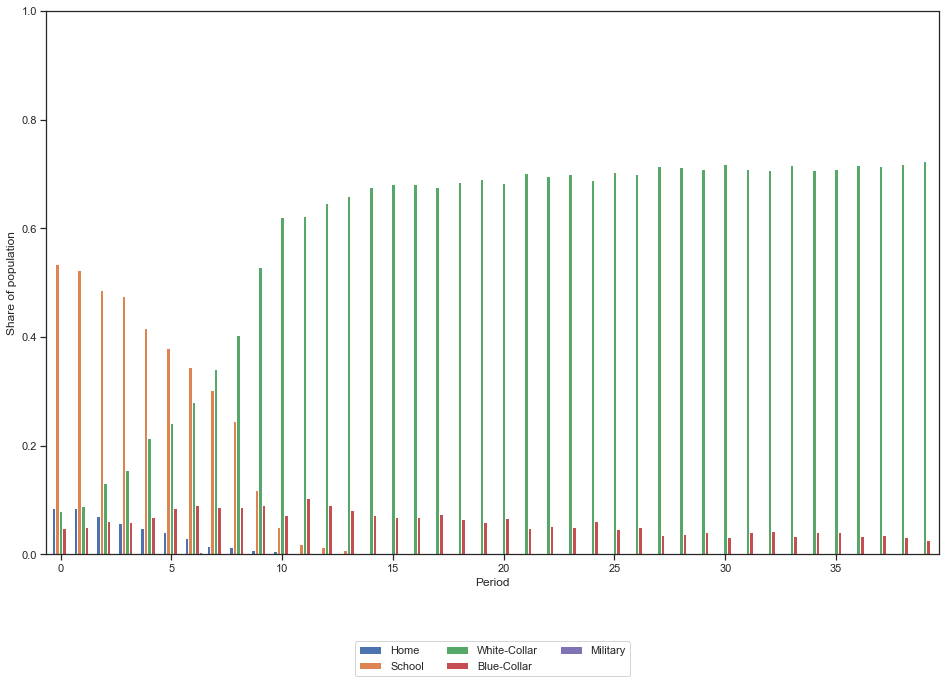

In [26]:
# plot share of population in basic model
share_basic(respy_basic, ax)

In [43]:
# load pickled extended model data
respy_df = pd.read_pickle("simulated_data/kw_97_extended.pickle")

# extended model dataset
respy_df.head()

,Identifier,Period,Choice,Wage,Experience_A,Experience_B,Experience_Mil,Experience_Edu,Lagged_Choice,Type,...,Value_Function_B,Value_Function_Mil,Value_Function_Edu,Value_Function_Home,Shock_Reward_A,Shock_Reward_B,Shock_Reward_Mil,Shock_Reward_Edu,Shock_Reward_Home,Discount_Rate
0,0,0,edu,nan,0,0,0,7,edu,3,...,"306,941.74","291,188.56","327,536.11","298,934.04",0.81,1.59,1.13,"7,394.31","-5,095.05",0.94
1,0,1,edu,nan,0,0,0,8,edu,3,...,"303,949.28","298,256.86","339,370.82","315,889.23",1.19,0.54,0.97,"13,345.80","5,644.50",0.94
2,0,2,edu,nan,0,0,0,9,edu,3,...,"317,638.02","310,930.19","345,459.85","321,156.82",1.23,0.91,0.95,"12,187.50","1,449.01",0.94
3,0,3,edu,nan,0,0,0,10,edu,3,...,"331,994.59","323,824.95","354,246.04","328,885.47",1.60,1.00,0.89,"7,304.61","-3,543.94",0.94
4,0,4,edu,nan,0,0,0,11,edu,3,...,"347,635.57","347,094.58","360,061.85","355,282.38",0.83,0.98,1.62,"-1,852.96","8,135.87",0.94


The extended dynamic programming model however forecasts less white-collar employment and more blue-collar employment over the life cycle than the basic model does as seen below:

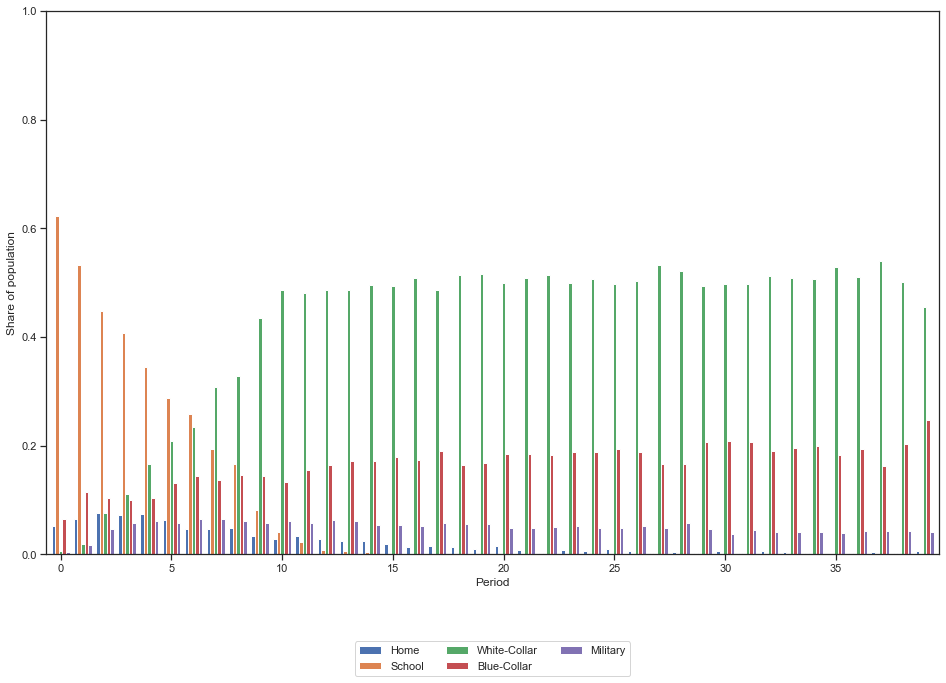

In [28]:
# share of population in extended model
share_extended(respy_df, ax)

##### Plotting value functions per choice
Here, l plot the per choice value functions using both the basic and extended simulated datasets.

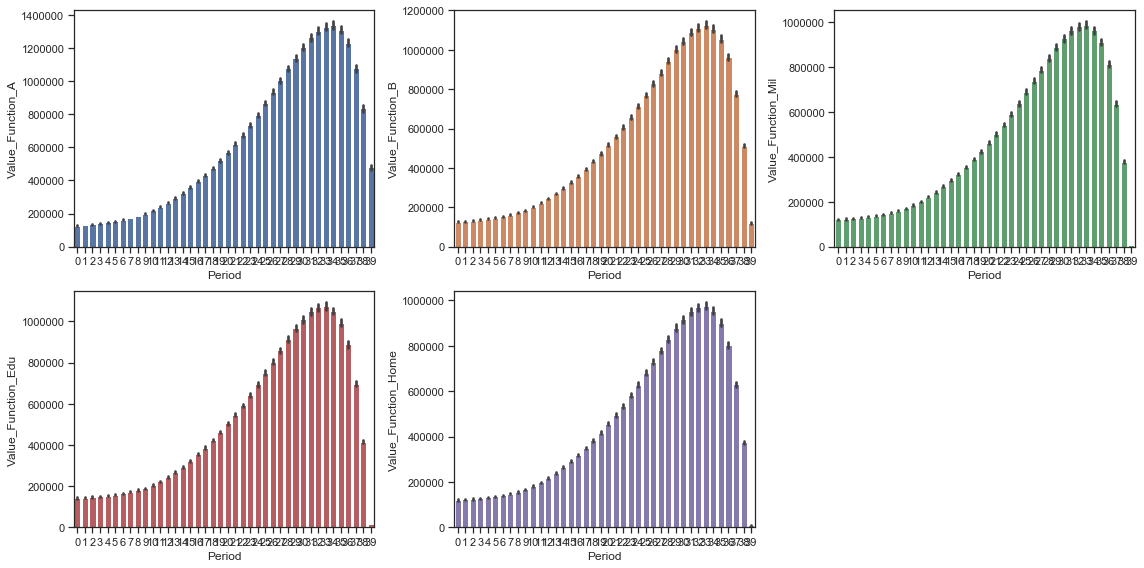

In [29]:
# Plot value functions for basic model
value_func_basic(respy_basic, ax)

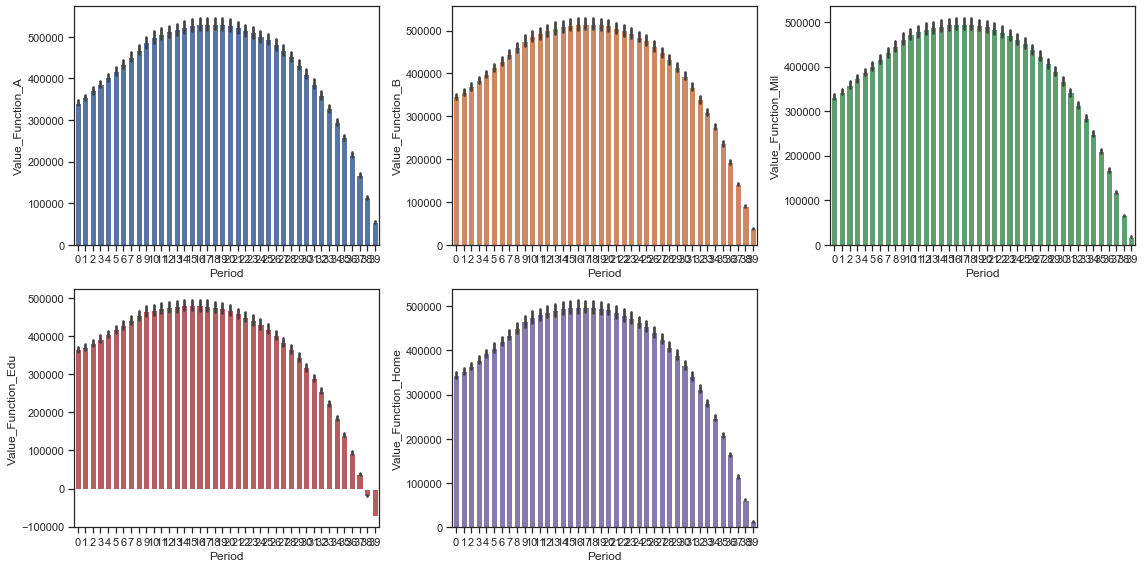

In [30]:
# Plot value functions for extended model
value_func_extended(respy_df, ax)

#### Construct covariance matrices and calculate standard errors

For purposes of standard error calculations, l use the real dataset from the respy. I make the assumption that the missing lagged choices are all schooling and impute that into the data.

In [57]:
# load real dataset from extended model
params, options, extended_df = rp.get_example_model("kw_97_extended")

extended_df.head()

,Identifier,Period,Choice,Wage,Experience_A,Experience_B,Experience_Mil,Experience_Edu,Lagged_Choice
0,0,0,edu,nan,0,0,0,11,NaN
1,0,1,edu,nan,0,0,0,12,edu
2,0,2,edu,nan,0,0,0,13,edu
3,0,3,edu,nan,0,0,0,14,edu
4,0,4,edu,nan,0,0,0,15,edu


In [58]:
# fill missing lagged choices
extended_df.Lagged_Choice = extended_df.Lagged_Choice.fillna("edu")

I then use the likelihood functions from *respy* so as to get the hessian and jacobian criterion functions. 

In [61]:
# jacobian and hessian likelihood functions
hessian_crit_func = get_crit_func(params, options, extended_df, version='log_like')
jacobian_crit_func = get_crit_func(params, options, extended_df, version='log_like_obs')

Here, l use the hessian and jacobian criterion functions from the previous steps to get the hessian, jacobian and HJJH covariance matrices using the *estimagic* package.

In [ ]:
# covariance matrices here.

##### Standard errors using the hessian matrix

In [ ]:
# standard errors

##### Standard errors using the jacobian matrix

In [ ]:
# standard errors

##### Standard errors using the HJJH sandwich matrix

In [ ]:
# standard errors

# Section V: Results

#### A summary of the paper's findings
The authors also use the estimates to predict the impact of a 2,000 college tuition subsidy on schooling decisions and other life cycle outcomes. This ties in with what motivates the paper as discussed in section II. Results suggest that such a subsidy would increase high school graduation rates by 3.5 percentage points and increase college graduation rates by 8.4 percentage points. However, the results also indicate that such a subsidy would have a negligible impact on the expected present value of lifetime utility. Those who would benefit most are the types with high endowments of white-collar and school-related skills, that is, those who, for the most part, would have gone to college even without the subsidy. Those who are induced to attend college by the subsidy are primarily those with a comparative advantage in blue-collar occupations and poor endowments of school-related skills. Because most of the subsidy is needed simply to bring such people to the margin of indifference between college attendance and other options (in the model individuals are not financially constrained with respect to college tuition costs), it will tend to have little effect on their lifetime wealth. Tuition subsidies of this magnitude do little to compensate for utility differences arising from endowments. The result that college tuition subsidies can have little effect on lifetime wealth follows, in part, from a more fundamental finding: that inequality in skill endowments ‘‘explains’’ the bulk of the variation in lifetime utility. 

#### Does the extended model do a better job?
The authors apply the same criteria for judging the success of the extended model as for the basic model. I replicate the main results from the extended model in section 4 above. They find that the extended human capital investment model does a good job of fitting the data on the educational and occupational choices of this cohort. The model, however, is a considerable extension beyond the basic human capital investment model. 

# References

- Keane, M. P. & Wopin, W. I. (1997). [The career Decisions of Young Men.](https://www.jstor.org/stable/10.1086/262080)
 *Journal of Political Economy, 105(3): 473-552.*
 
- Keane, M. P. & Wopin, W. I., & Vytlacil, E. J. (1994). 
[The Solution and Estimation of Discrete Choice Dynamic Programming Models by Simulation and Interpolation: Monte Carlo Evidence.](https://www.jstor.org/stable/2109768)  *The Review of Economics and Statistics, 76(4): 648-672.*

- Marno Verbeek. A Guide to Modern Econometrics, *Fifth Edition*.

- [Statmodels implementation of the HJJH covariance matrix](https://tinyurl.com/yym5d4cw).
